In [21]:
# from google.colab import drive
# drive.mount("/content/gdrive")
# !ls "/content/gdrive/MyDrive/data"

In [22]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.applications import MobileNetV2
import tensorflow_datasets as tfds
# Helper libraries
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import matplotlib.pyplot as plt

print(tf.__version__)

2.12.0


  CIFAR-10 是一个常用于训练机器学习和计算机视觉算法的图像数据集。它是用于机器学习研究的最广泛使用的数据集之一。
  CIFAR-10 数据集包含 60,000 张 32x32 像素的彩色图像，共分为 10 个类别，每个类别有 6,000 张图像。这些类别包括：飞机、汽车、鸟、猫、鹿、狗、青蛙、马、船和卡车。
  数据集被分为训练集和测试集。训练集包含 50,000 张图像，测试集包含 10,000 张图像。

In [23]:
# 使用keras的数据集
cifar10 = tf.keras.datasets.cifar10

In [24]:
# 划分测试集、训练集
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [25]:
# 查看数据的情况
print("the shape of train_images:",train_images.shape)
print("the length of train_images:",len(train_images))
print("the shape of test_images:",test_images.shape)
print("the length of test_images:",len(test_images))

print("\nthe content in train_labels:",train_labels)


the shape of train_images: (50000, 32, 32, 3)
the length of train_images: 50000
the shape of test_images: (10000, 32, 32, 3)
the length of test_images: 10000

the content in train_labels: [[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


In [26]:
# 设置labels对应的名称
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

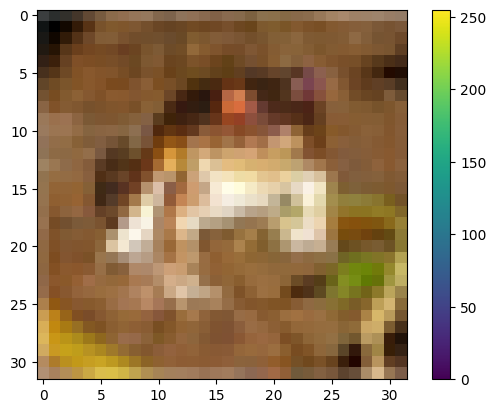

In [27]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [28]:
# 归一化
train_images = train_images / 255.0
test_images = test_images / 255.0

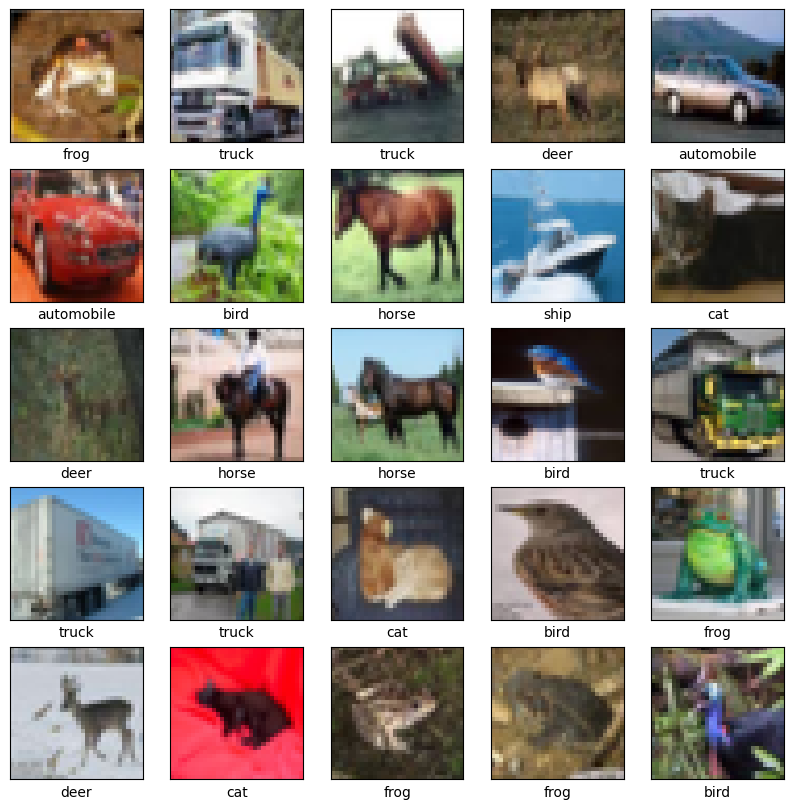

In [30]:
# show first 25 images and labels
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

# **define model**

接下来四个模型分别为:

1.   自行构建的模型:模型结构简单,不能很好的拟合模型
2.   使用inception_v1作为预训练模型
3.   使用inception_v1作为预训练模型,但是对图片进行resize.跟同未resize的2没有明显区别
4.   使用inception_resnet_v2作为预训练模型.这个模型的参数远大于v1版本,效果不错,但是训练的时间很久
5.   使用efficientnet作为预训练模型.这个预训练模型同本次的内容关系不大,导致效果基本1相同,即使二者的模型参数不在同一个量级.
6.   使用mobilenet_v2_100_128作为预训练模型.训练时间不算很快,但是效果可以和4比拟




In [12]:
def create_model_simple():
  model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=(32, 32,3)),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(10)
  ])
  model.compile(optimizer='adam',
         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
         metrics=['accuracy'])
  return model

def create_model_inception_v1():
  model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v1/classification/5"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
  ])
  model.compile(optimizer='adam',
         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
         metrics=['accuracy'])
  return model

def create_model_inception_v1_Resize():
  model = tf.keras.Sequential([
    Resizing(128,128),
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v1/classification/5"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
  ])
  model.compile(optimizer='adam',
         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
         metrics=['accuracy'])
  return model

def create_model_inception_resnet_v2():
  model = tf.keras.Sequential([
    Resizing(128,128),
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/5"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
  ])
  model.compile(optimizer='adam',
         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
         metrics=['accuracy'])
  return model

def create_model_efficientnet():
  model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/classification/1"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
  ])
  model.compile(optimizer='adam',
         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
         metrics=['accuracy'])
  return model
  
def create_model_mobilenet():
  model = tf.keras.Sequential([
    Resizing(128,128),
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/classification/5"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
  ])
  model.compile(optimizer='adam',
         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
         metrics=['accuracy'])
  return model

In [32]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)

# train model


## **model_simple**

In [15]:
model_simple=create_model_simple()

In [16]:
# train model
history_simple=model_simple.fit(train_images, train_labels,validation_data=(test_images,test_labels), epochs=10, callbacks=[early_stopping])

Epoch 1/10
1563/1563 [==============================] - 12s 5ms/step - loss: 1.8992 - accuracy: 0.3211 - val_loss: 1.8320 - val_accuracy: 0.3310
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.7242 - accuracy: 0.3825 - val_loss: 1.6803 - val_accuracy: 0.4038
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6655 - accuracy: 0.4061 - val_loss: 1.6194 - val_accuracy: 0.4204
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6282 - accuracy: 0.4208 - val_loss: 1.6145 - val_accuracy: 0.4282
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6038 - accuracy: 0.4272 - val_loss: 1.5863 - val_accuracy: 0.4378
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5815 - accuracy: 0.4361 - val_loss: 1.5939 - val_accuracy: 0.4294
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5678 - accuracy: 0.4415 - val_loss: 1.6377 - val_accuracy

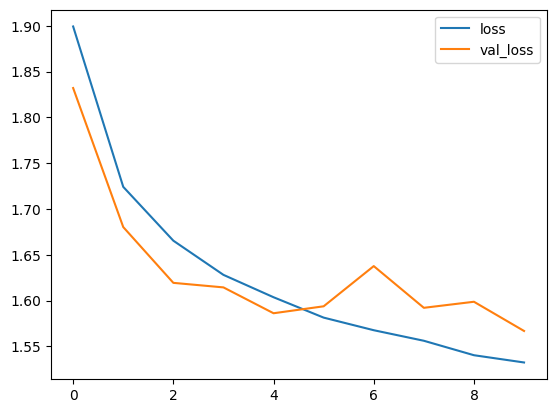

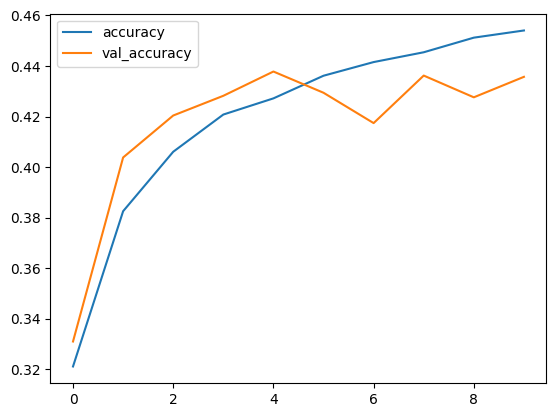

In [17]:
history_frame_simple = pd.DataFrame(history_simple.history)
history_frame_simple.loc[:, ['loss', 'val_loss']].plot()
history_frame_simple.loc[:, ['accuracy', 'val_accuracy']].plot();

## **model_inception_v1**

In [18]:
model_inception_v1_Resize=create_model_inception_v1_Resize()

In [19]:
# train model
history_inception_v1_Resize=model_inception_v1_Resize.fit(train_images, train_labels,validation_data=(test_images,test_labels), epochs=10, callbacks=[early_stopping])

Epoch 1/10
1563/1563 [==============================] - 23s 11ms/step - loss: 1.3647 - accuracy: 0.5262 - val_loss: 1.2612 - val_accuracy: 0.5543
Epoch 2/10
1563/1563 [==============================] - 16s 10ms/step - loss: 1.1888 - accuracy: 0.5800 - val_loss: 1.2249 - val_accuracy: 0.5693
Epoch 3/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.1370 - accuracy: 0.5997 - val_loss: 1.2254 - val_accuracy: 0.5740
Epoch 4/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.0979 - accuracy: 0.6085 - val_loss: 1.2251 - val_accuracy: 0.5737
Epoch 5/10
1563/1563 [==============================] - 15s 10ms/step - loss: 1.0649 - accuracy: 0.6224 - val_loss: 1.2162 - val_accuracy: 0.5749
Epoch 6/10
1563/1563 [==============================] - 15s 10ms/step - loss: 1.0319 - accuracy: 0.6332 - val_loss: 1.2379 - val_accuracy: 0.5783
Epoch 7/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.0047 - accuracy: 0.6430 - val_loss: 1.2568 - va

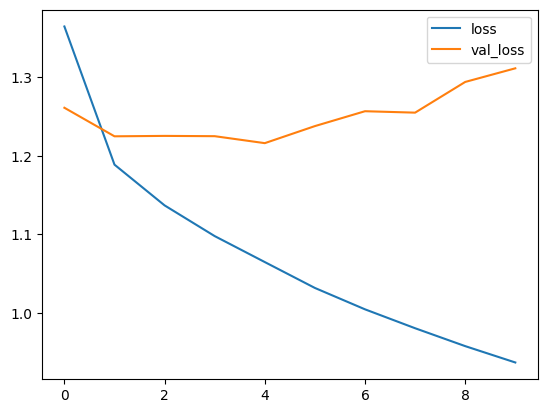

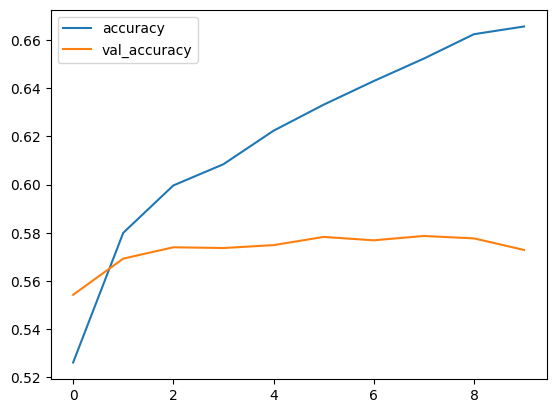

In [20]:
history_frame_inception_v1_Resize = pd.DataFrame(history_inception_v1_Resize.history)
history_frame_inception_v1_Resize.loc[:, ['loss', 'val_loss']].plot()
history_frame_inception_v1_Resize.loc[:, ['accuracy', 'val_accuracy']].plot();

## **model_inception_v1_Resize**

In [63]:
model_inception_v1=create_model_inception_v1()

In [64]:
# train model
history_inception_v1=model_inception_v1.fit(train_images, train_labels,validation_data=(test_images,test_labels), epochs=10, callbacks=[early_stopping])

Epoch 1/10
1563/1563 [==============================] - 21s 10ms/step - loss: 1.3568 - accuracy: 0.5264 - val_loss: 1.2586 - val_accuracy: 0.5547
Epoch 2/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.1874 - accuracy: 0.5781 - val_loss: 1.2319 - val_accuracy: 0.5664
Epoch 3/10
1563/1563 [==============================] - 13s 9ms/step - loss: 1.1359 - accuracy: 0.5971 - val_loss: 1.2083 - val_accuracy: 0.5722
Epoch 4/10
1563/1563 [==============================] - 13s 9ms/step - loss: 1.0956 - accuracy: 0.6102 - val_loss: 1.2305 - val_accuracy: 0.5635
Epoch 5/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.0647 - accuracy: 0.6205 - val_loss: 1.2329 - val_accuracy: 0.5674
Epoch 6/10
1563/1563 [==============================] - 13s 9ms/step - loss: 1.0334 - accuracy: 0.6331 - val_loss: 1.2277 - val_accuracy: 0.5768
Epoch 7/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.0094 - accuracy: 0.6399 - val_loss: 1.2537 - val_a

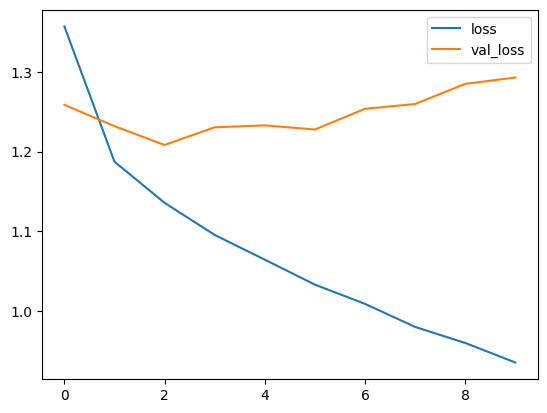

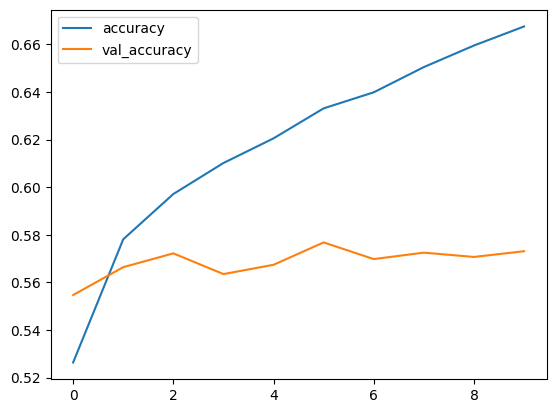

In [65]:
history_frame_inception_v1 = pd.DataFrame(history_inception_v1.history)
history_frame_inception_v1.loc[:, ['loss', 'val_loss']].plot()
history_frame_inception_v1.loc[:, ['accuracy', 'val_accuracy']].plot();

##  **model_inception_resnet_v2**

In [31]:
model_inception_resnet_v2=create_model_inception_resnet_v2()

In [32]:
# train model
history_inception_resnet_v2=model_inception_resnet_v2.fit(train_images, train_labels,validation_data=(test_images,test_labels), epochs=10, callbacks=[early_stopping])

Epoch 1/10
1563/1563 [==============================] - 137s 74ms/step - loss: 0.7148 - accuracy: 0.7901 - val_loss: 0.5653 - val_accuracy: 0.8181
Epoch 2/10
1563/1563 [==============================] - 109s 70ms/step - loss: 0.4999 - accuracy: 0.8343 - val_loss: 0.5390 - val_accuracy: 0.8244
Epoch 3/10
1563/1563 [==============================] - 114s 73ms/step - loss: 0.4606 - accuracy: 0.8456 - val_loss: 0.5375 - val_accuracy: 0.8257
Epoch 4/10
1563/1563 [==============================] - 111s 71ms/step - loss: 0.4388 - accuracy: 0.8521 - val_loss: 0.5316 - val_accuracy: 0.8341
Epoch 5/10
1563/1563 [==============================] - 113s 73ms/step - loss: 0.4209 - accuracy: 0.8576 - val_loss: 0.5463 - val_accuracy: 0.8287
Epoch 6/10
1563/1563 [==============================] - 114s 73ms/step - loss: 0.4015 - accuracy: 0.8646 - val_loss: 0.5286 - val_accuracy: 0.8354
Epoch 7/10
1563/1563 [==============================] - 113s 73ms/step - loss: 0.3879 - accuracy: 0.8682 - val_loss: 0

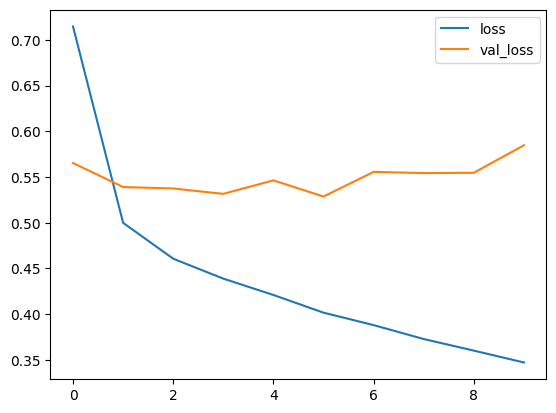

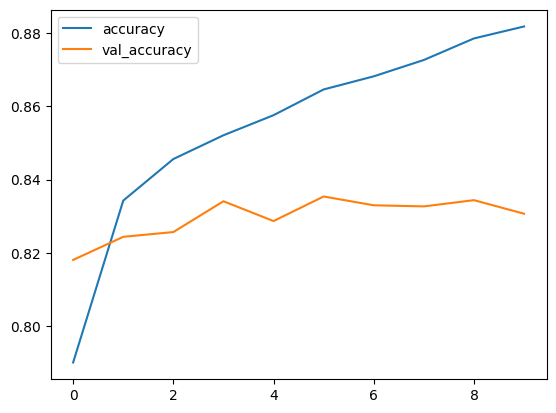

In [33]:
history_frame_inception_resnet_v2 = pd.DataFrame(history_inception_resnet_v2.history)
history_frame_inception_resnet_v2.loc[:, ['loss', 'val_loss']].plot()
history_frame_inception_resnet_v2.loc[:, ['accuracy', 'val_accuracy']].plot();

## **model_efficientnet**

In [23]:
model_efficientnet=create_model_efficientnet()

In [24]:
# train model
history_efficientnet=model_efficientnet.fit(train_images, train_labels,validation_data=(test_images,test_labels), epochs=10, callbacks=[early_stopping])

Epoch 1/10
1563/1563 [==============================] - 43s 14ms/step - loss: 2.0687 - accuracy: 0.2646 - val_loss: 1.8903 - val_accuracy: 0.3233
Epoch 2/10
1563/1563 [==============================] - 20s 12ms/step - loss: 1.8255 - accuracy: 0.3481 - val_loss: 1.7725 - val_accuracy: 0.3659
Epoch 3/10
1563/1563 [==============================] - 24s 16ms/step - loss: 1.7272 - accuracy: 0.3805 - val_loss: 1.6893 - val_accuracy: 0.3896
Epoch 4/10
1563/1563 [==============================] - 21s 13ms/step - loss: 1.6577 - accuracy: 0.4018 - val_loss: 1.6325 - val_accuracy: 0.4136
Epoch 5/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.6091 - accuracy: 0.4185 - val_loss: 1.5919 - val_accuracy: 0.4245
Epoch 6/10
1563/1563 [==============================] - 20s 13ms/step - loss: 1.5733 - accuracy: 0.4303 - val_loss: 1.5618 - val_accuracy: 0.4363
Epoch 7/10
1563/1563 [==============================] - 21s 13ms/step - loss: 1.5447 - accuracy: 0.4413 - val_loss: 1.5386 -

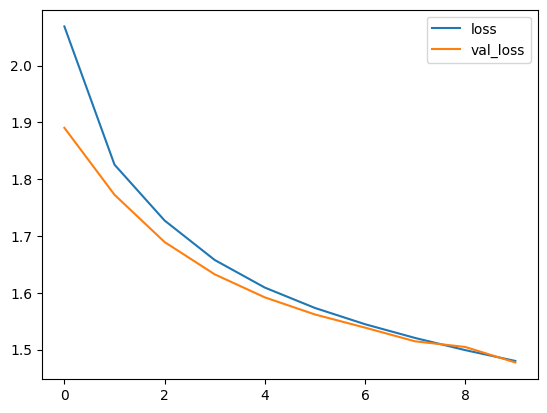

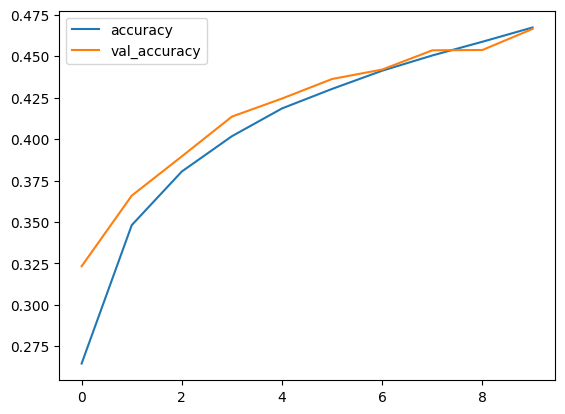

In [25]:
history_frame_efficientnet = pd.DataFrame(history_efficientnet.history)
history_frame_efficientnet.loc[:, ['loss', 'val_loss']].plot()
history_frame_efficientnet.loc[:, ['accuracy', 'val_accuracy']].plot();

## **model_mobilenet**

In [26]:
model_mobilenet=create_model_mobilenet()

In [27]:
# train model
history_mobilenet=model_mobilenet.fit(train_images, train_labels,validation_data=(test_images,test_labels), epochs=10, callbacks=[early_stopping])

Epoch 1/10
1563/1563 [==============================] - 34s 19ms/step - loss: 0.5376 - accuracy: 0.8166 - val_loss: 0.4703 - val_accuracy: 0.8360
Epoch 2/10
1563/1563 [==============================] - 30s 19ms/step - loss: 0.4093 - accuracy: 0.8573 - val_loss: 0.4457 - val_accuracy: 0.8455
Epoch 3/10
1563/1563 [==============================] - 29s 18ms/step - loss: 0.3649 - accuracy: 0.8723 - val_loss: 0.4465 - val_accuracy: 0.8484
Epoch 4/10
1563/1563 [==============================] - 27s 18ms/step - loss: 0.3289 - accuracy: 0.8825 - val_loss: 0.4594 - val_accuracy: 0.8461
Epoch 5/10
1563/1563 [==============================] - 27s 17ms/step - loss: 0.2997 - accuracy: 0.8944 - val_loss: 0.4722 - val_accuracy: 0.8466
Epoch 6/10
1563/1563 [==============================] - 27s 17ms/step - loss: 0.2754 - accuracy: 0.9025 - val_loss: 0.4747 - val_accuracy: 0.8489
Epoch 7/10
1563/1563 [==============================] - 27s 17ms/step - loss: 0.2507 - accuracy: 0.9095 - val_loss: 0.4959 -

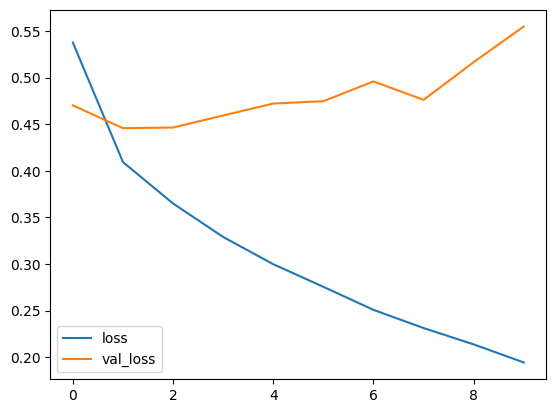

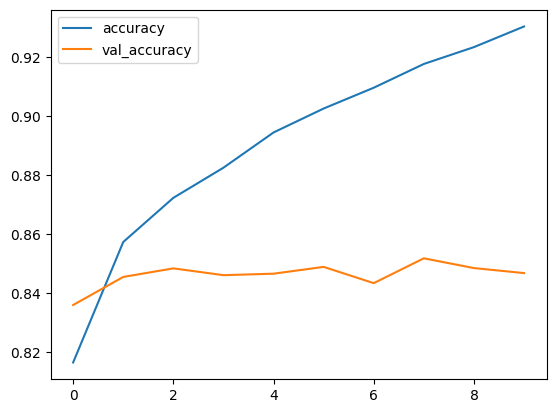

In [28]:
history_frame_mobilenet = pd.DataFrame(history_mobilenet.history)
history_frame_mobilenet.loc[:, ['loss', 'val_loss']].plot()
history_frame_mobilenet.loc[:, ['accuracy', 'val_accuracy']].plot();

# 对比较合适的预训练模型mobilenet进行讨论

**model_mobilenet 测试部分**

上述已经展示了冻结预训练模型的效果,接下来将展示半冻结,不冻结预训练模型的效果

可以看到,对keras.applications的MobileNetV2模型来说:

半冻结前半部分的模型表现最好,全冻结其次,不冻结更次,随机一半冻结的效果最差

在迁移学习中，通常会使用预训练模型作为新模型的基础。预训练模型通常是在大型数据集上训练的，已经学习到了很多有用的特征。通过冻结预训练模型的部分或全部层，可以保留这些特征，并将它们用于新模型。

在实践中，冻结预训练模型的前半部分通常会取得较好的效果。这是因为预训练模型的前几层通常负责提取低级特征，如边缘、角点和纹理等。这些特征通常在不同的数据集和任务中都是通用的。因此，通过冻结预训练模型的前半部分，可以保留这些有用的低级特征，并将它们用于新模型。

相比之下，预训练模型的后几层通常负责提取高级特征，这些特征更具任务相关性。因此，在迁移学习中，通常会解冻预训练模型的后几层，并对它们进行微调，以便它们能够更好地适应新任务。

全冻结预训练模型也可能取得较好的效果，但这取决于新任务与原始任务的相似程度。如果新任务与原始任务非常相似，那么全冻结预训练模型可能会取得较好的效果。但如果新任务与原始任务差异较大，则全冻结预训练模型可能无法很好地适应新任务。

不冻结预训练模型可能会导致过拟合或欠拟合。如果新数据集较小，则不冻结预训练模型可能会导致过拟合。如果新数据集较大，则不冻结预训练模型可能会导致欠拟合。

随机冻结预训练模型的一半可能会导致不稳定的结果。由于随机性，有些重要的层可能被冻结，而一些不太重要的层可能被解冻。这可能会导致模型无法很好地适应新任务。

总之，在迁移学习中，冻结预训练模型的方式会影响新模型的性能。通常情况下，冻结预训练模型的前半部分会取得较好的效果。但具体情况还取决于新任务与原始任务的相似程度、新数据集的大小等因素。

## 冻结MobileNet,使用keras.applications的模型

In [73]:
# 创建一个预训练的 MobileNetV2 模型
mobilenet_origin_fullFreezed = MobileNetV2(weights='imagenet')

# 获取模型的输入和倒数第二层的输出
input_tensor_fullFreezed = mobilenet_origin_fullFreezed.input
output_tensor_fullFreezed = mobilenet_origin_fullFreezed.layers[-2].output

In [74]:
mobilenet_fullFreezed = tf.keras.Model(inputs=input_tensor_fullFreezed, outputs=output_tensor_fullFreezed)
mobilenet_fullFreezed.trainable = False

In [75]:
def create_model_mobilenet_fullFreezed():
  model = tf.keras.Sequential([
    Resizing(224,224),
    mobilenet_fullFreezed,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
  ])
  model.compile(optimizer='adam',
         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
         metrics=['accuracy'])
  return model
model_mobilenet_fullFreezed=create_model_mobilenet_fullFreezed()

In [79]:
# train model 
history_mobilenet_fullFreezed=model_mobilenet_fullFreezed.fit(train_images, train_labels,validation_data=(test_images,test_labels), epochs=10, callbacks=[early_stopping])

Epoch 1/10
1563/1563 [==============================] - 72s 44ms/step - loss: 0.6677 - accuracy: 0.7680 - val_loss: 0.6196 - val_accuracy: 0.7856
Epoch 2/10
1563/1563 [==============================] - 77s 49ms/step - loss: 0.5249 - accuracy: 0.8164 - val_loss: 0.5532 - val_accuracy: 0.8098
Epoch 3/10
1563/1563 [==============================] - 67s 43ms/step - loss: 0.4752 - accuracy: 0.8330 - val_loss: 0.5762 - val_accuracy: 0.7975
Epoch 4/10
1563/1563 [==============================] - 78s 50ms/step - loss: 0.4389 - accuracy: 0.8432 - val_loss: 0.5515 - val_accuracy: 0.8151
Epoch 5/10
1563/1563 [==============================] - 77s 49ms/step - loss: 0.4018 - accuracy: 0.8573 - val_loss: 0.5604 - val_accuracy: 0.8118
Epoch 6/10
1563/1563 [==============================] - 77s 49ms/step - loss: 0.3729 - accuracy: 0.8676 - val_loss: 0.5399 - val_accuracy: 0.8188
Epoch 7/10
1563/1563 [==============================] - 67s 43ms/step - loss: 0.3446 - accuracy: 0.8767 - val_loss: 0.5644 -

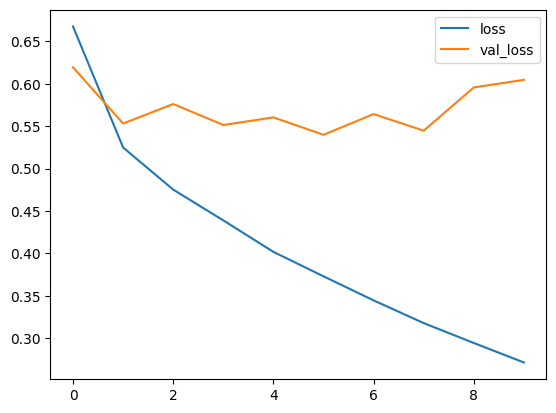

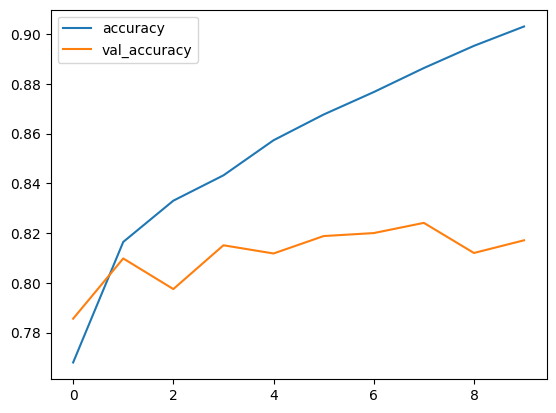

In [81]:
history_frame_mobilenet_fullFreezed = pd.DataFrame(history_mobilenet_fullFreezed.history)
history_frame_mobilenet_fullFreezed.loc[:, ['loss', 'val_loss']].plot()
history_frame_mobilenet_fullFreezed.loc[:, ['accuracy', 'val_accuracy']].plot();

In [80]:
model_mobilenet_fullFreezed.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_10 (Resizing)      (224, 224, 3)             0         
                                                                 
 model_9 (Functional)        (None, 1280)              2257984   
                                                                 
 flatten_8 (Flatten)         multiple                  0         
                                                                 
 dense_16 (Dense)            multiple                  163968    
                                                                 
 dense_17 (Dense)            multiple                  1290      
                                                                 
Total params: 2,423,242
Trainable params: 165,258
Non-trainable params: 2,257,984
_________________________________________________________________


## 半冻结MobileNet的前半部分.

In [50]:
# 创建一个预训练的 MobileNetV2 模型
mobilenet_origin_halfFreezed = MobileNetV2(weights='imagenet')

# 获取模型的输入和倒数第二层的输出
input_tensor_halfFreezed = mobilenet_origin_halfFreezed.input
output_tensor_halfFreezed = mobilenet_origin_halfFreezed.layers[-2].output

In [66]:
# 创建一个半冻结预训练模型
mobilenet_halfFreezed = tf.keras.Model(inputs=input_tensor_halfFreezed, outputs=output_tensor_halfFreezed)

# 计算模型中层数量的一半
num_layers = len(mobilenet_halfFreezed.layers)
half_layers = num_layers // 2

# 冻结前半部分的层
for layer in mobilenet_halfFreezed.layers[:half_layers]:
    layer.trainable = False

# 显示每一层的 trainable 属性
for layer in mobilenet_halfFreezed.layers:
    print(f"{layer.name}: {layer.trainable}")

input_2: False
Conv1: False
bn_Conv1: False
Conv1_relu: False
expanded_conv_depthwise: False
expanded_conv_depthwise_BN: False
expanded_conv_depthwise_relu: False
expanded_conv_project: False
expanded_conv_project_BN: False
block_1_expand: False
block_1_expand_BN: False
block_1_expand_relu: False
block_1_pad: False
block_1_depthwise: False
block_1_depthwise_BN: False
block_1_depthwise_relu: False
block_1_project: False
block_1_project_BN: False
block_2_expand: False
block_2_expand_BN: False
block_2_expand_relu: False
block_2_depthwise: False
block_2_depthwise_BN: False
block_2_depthwise_relu: False
block_2_project: False
block_2_project_BN: False
block_2_add: False
block_3_expand: False
block_3_expand_BN: False
block_3_expand_relu: False
block_3_pad: False
block_3_depthwise: False
block_3_depthwise_BN: False
block_3_depthwise_relu: False
block_3_project: False
block_3_project_BN: False
block_4_expand: False
block_4_expand_BN: False
block_4_expand_relu: False
block_4_depthwise: False
bl

In [52]:
def create_model_mobilenet_halfFreezed():
  model = tf.keras.Sequential([
    Resizing(224,224),
    mobilenet_halfFreezed,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
  ])
  model.compile(optimizer='adam',
         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
         metrics=['accuracy'])
  return model
model_mobilenet_halfFreezed=create_model_mobilenet_halfFreezed()

In [62]:
model_mobilenet_halfFreezed.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_7 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 model_5 (Functional)        (None, 1280)              2257984   
                                                                 
 flatten_4 (Flatten)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               163968    
                                                                 
 dense_9 (Dense)             (None, 10)                1290      
                                                                 
Total params: 2,423,242
Trainable params: 2,228,746
Non-trainable params: 194,496
_________________________________________________________________


In [56]:
# train model 
history_mobilenet_halfFreezed=model_mobilenet_halfFreezed.fit(train_images, train_labels,validation_data=(test_images,test_labels), epochs=10, callbacks=[early_stopping])

Epoch 1/10
1563/1563 [==============================] - 135s 75ms/step - loss: 0.5796 - accuracy: 0.8065 - val_loss: 6.1426 - val_accuracy: 0.4237
Epoch 2/10
1563/1563 [==============================] - 111s 71ms/step - loss: 0.3743 - accuracy: 0.8733 - val_loss: 1.7401 - val_accuracy: 0.6544
Epoch 3/10
1563/1563 [==============================] - 111s 71ms/step - loss: 0.2984 - accuracy: 0.9010 - val_loss: 1.7261 - val_accuracy: 0.6609
Epoch 4/10
1563/1563 [==============================] - 101s 65ms/step - loss: 0.2559 - accuracy: 0.9136 - val_loss: 0.9309 - val_accuracy: 0.7807
Epoch 5/10
1563/1563 [==============================] - 111s 71ms/step - loss: 0.2154 - accuracy: 0.9262 - val_loss: 1.1448 - val_accuracy: 0.7693
Epoch 6/10
1563/1563 [==============================] - 101s 65ms/step - loss: 0.1855 - accuracy: 0.9370 - val_loss: 1.1116 - val_accuracy: 0.7714
Epoch 7/10
1563/1563 [==============================] - 111s 71ms/step - loss: 0.1559 - accuracy: 0.9476 - val_loss: 0

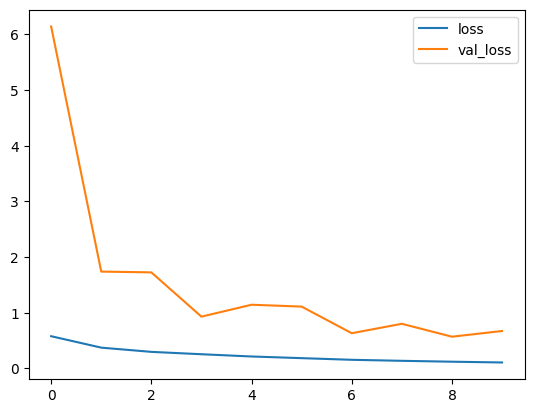

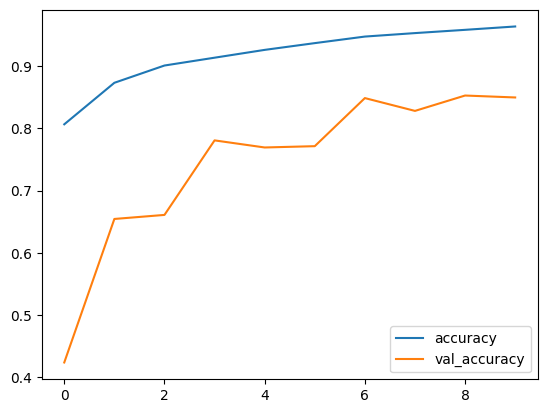

In [57]:
history_frame_mobilenet_halfFreezed = pd.DataFrame(history_mobilenet_halfFreezed.history)
history_frame_mobilenet_halfFreezed.loc[:, ['loss', 'val_loss']].plot()
history_frame_mobilenet_halfFreezed.loc[:, ['accuracy', 'val_accuracy']].plot();

## 半冻结MobileNet的随机一半.

In [53]:
# 创建一个预训练的 MobileNetV2 模型
mobilenet_origin_randomFreezed = MobileNetV2(weights='imagenet')

# 获取模型的输入和倒数第二层的输出
input_tensor_randomFreezed = mobilenet_origin_randomFreezed.input
output_tensor_randomFreezed = mobilenet_origin_randomFreezed.layers[-2].output

In [54]:
import random

# 创建一个随机半冻结预训练模型
mobilenet_randomFreezed = tf.keras.Model(inputs=input_tensor_randomFreezed, outputs=output_tensor_randomFreezed)

# 计算模型中层数量的一半
num_layers = len(mobilenet_randomFreezed.layers)
half_layers = num_layers // 2

# 随机选择一半的层
layers_to_freeze = random.sample(mobilenet_randomFreezed.layers, k=half_layers)

# 冻结选定的层
for layer in layers_to_freeze:
    layer.trainable = False

# 显示每一层的 trainable 属性
# for layer in mobilenet_halfFreezed.layers:
#     print(f"{layer.name}: {layer.trainable}") 

In [55]:
def create_model_mobilenet_randomFreezed():
  model = tf.keras.Sequential([
    Resizing(224,224),
    mobilenet_randomFreezed,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
  ])
  model.compile(optimizer='adam',
         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
         metrics=['accuracy'])
  return model
model_mobilenet_randomFreezed=create_model_mobilenet_randomFreezed()

In [61]:
model_mobilenet_randomFreezed.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_8 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 model_6 (Functional)        (None, 1280)              2257984   
                                                                 
 flatten_5 (Flatten)         (None, 1280)              0         
                                                                 
 dense_10 (Dense)            (None, 128)               163968    
                                                                 
 dense_11 (Dense)            (None, 10)                1290      
                                                                 
Total params: 2,423,242
Trainable params: 1,154,874
Non-trainable params: 1,268,368
_________________________________________________________________


In [58]:
# train model 
history_mobilenet_randomFreezed=model_mobilenet_randomFreezed.fit(train_images, train_labels,validation_data=(test_images,test_labels), epochs=10, callbacks=[early_stopping])

Epoch 1/10
1563/1563 [==============================] - 218s 129ms/step - loss: 0.4770 - accuracy: 0.8415 - val_loss: 2.4571 - val_accuracy: 0.4320
Epoch 2/10
1563/1563 [==============================] - 200s 128ms/step - loss: 0.2958 - accuracy: 0.9015 - val_loss: 2.4627 - val_accuracy: 0.5209
Epoch 3/10
1563/1563 [==============================] - 200s 128ms/step - loss: 0.2434 - accuracy: 0.9180 - val_loss: 4.0509 - val_accuracy: 0.3037
Epoch 4/10
1563/1563 [==============================] - 200s 128ms/step - loss: 0.2034 - accuracy: 0.9308 - val_loss: 1.3283 - val_accuracy: 0.6350
Epoch 5/10
1563/1563 [==============================] - 191s 122ms/step - loss: 0.1734 - accuracy: 0.9409 - val_loss: 2.2876 - val_accuracy: 0.5525
Epoch 6/10
1563/1563 [==============================] - 200s 128ms/step - loss: 0.1530 - accuracy: 0.9472 - val_loss: 0.9199 - val_accuracy: 0.7687
Epoch 7/10
1563/1563 [==============================] - 189s 121ms/step - loss: 0.1306 - accuracy: 0.9557 - val_

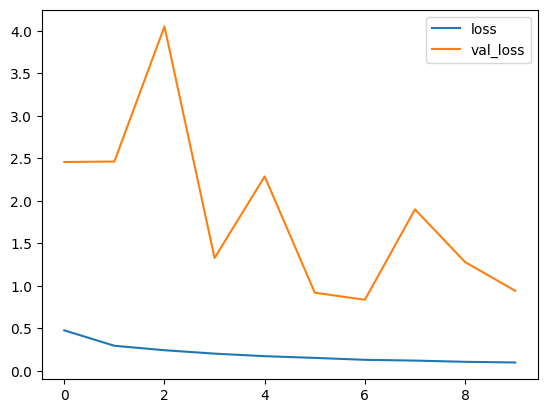

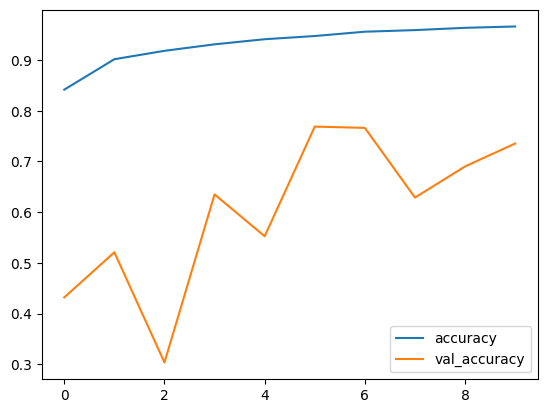

In [59]:
history_frame_mobilenet_randomFreezed = pd.DataFrame(history_mobilenet_randomFreezed.history)
history_frame_mobilenet_randomFreezed.loc[:, ['loss', 'val_loss']].plot()
history_frame_mobilenet_randomFreezed.loc[:, ['accuracy', 'val_accuracy']].plot();

## 不冻结MobileNet.

###使用keraslayer的模型

In [16]:
mobilenet_pretrained_trainable=hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/classification/5", trainable=True)

In [17]:
def create_model_mobilenet_trainable():
  model = tf.keras.Sequential([
    Resizing(128,128),
    mobilenet_pretrained_trainable,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
  ])
  model.compile(optimizer='adam',
         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
         metrics=['accuracy'])
  return model
model_mobilenet_trainable=create_model_mobilenet_trainable()

In [60]:
model_mobilenet_trainable.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 128, 128, 3)       0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 1001)              3540265   
                                                                 
 flatten (Flatten)           (None, 1001)              0         
                                                                 
 dense (Dense)               (None, 128)               128256    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 3,669,811
Trainable params: 3,635,699
Non-trainable params: 34,112
_________________________________________________________________


In [18]:
# train model
history_mobilenet_trainable=model_mobilenet_trainable.fit(train_images, train_labels,validation_data=(test_images,test_labels), epochs=10, callbacks=[early_stopping])

Epoch 1/10
1563/1563 [==============================] - 140s 61ms/step - loss: 0.8095 - accuracy: 0.7804 - val_loss: 0.6454 - val_accuracy: 0.8301
Epoch 2/10
1563/1563 [==============================] - 92s 59ms/step - loss: 0.5923 - accuracy: 0.8515 - val_loss: 0.6720 - val_accuracy: 0.8253
Epoch 3/10
1563/1563 [==============================] - 93s 60ms/step - loss: 0.5283 - accuracy: 0.8742 - val_loss: 0.7352 - val_accuracy: 0.8232
Epoch 4/10
1563/1563 [==============================] - 92s 59ms/step - loss: 0.5011 - accuracy: 0.8863 - val_loss: 0.5536 - val_accuracy: 0.8708
Epoch 5/10
1563/1563 [==============================] - 92s 59ms/step - loss: 0.4722 - accuracy: 0.8990 - val_loss: 0.5187 - val_accuracy: 0.8840
Epoch 6/10
1563/1563 [==============================] - 92s 59ms/step - loss: 0.4695 - accuracy: 0.9052 - val_loss: 0.6502 - val_accuracy: 0.8535
Epoch 7/10
1563/1563 [==============================] - 92s 59ms/step - loss: 0.4893 - accuracy: 0.9079 - val_loss: 0.5630 

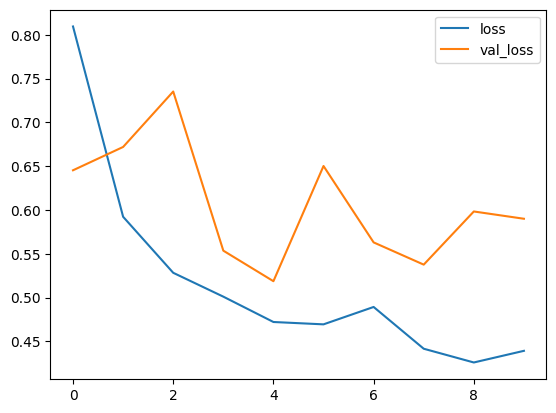

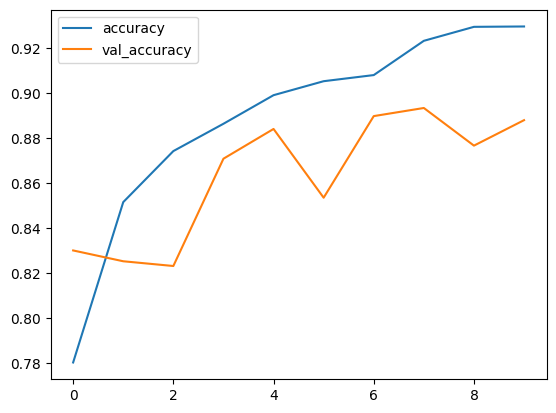

In [19]:
history_frame_mobilenet_trainable = pd.DataFrame(history_mobilenet_trainable.history)
history_frame_mobilenet_trainable.loc[:, ['loss', 'val_loss']].plot()
history_frame_mobilenet_trainable.loc[:, ['accuracy', 'val_accuracy']].plot();

###使用keras.applications的模型

In [67]:
# 创建一个预训练的 MobileNetV2 模型
mobilenet_applications = MobileNetV2(weights='imagenet')

# 获取模型的输入和倒数第二层的输出
input_tensor_trainable_applications = mobilenet_applications.input
output_tensor_trainable_applications = mobilenet_applications.layers[-2].output

In [68]:
mobilenet_trainable_applications = tf.keras.Model(inputs=input_tensor_trainable_applications, outputs=output_tensor_trainable_applications)

In [69]:
def create_model_mobilenet_trainable_applications():
  model = tf.keras.Sequential([
    Resizing(224,224),
    mobilenet_trainable_applications,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
  ])
  model.compile(optimizer='adam',
         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
         metrics=['accuracy'])
  return model
model_mobilenet_trainable_applications=create_model_mobilenet_trainable_applications()

In [72]:
model_mobilenet_trainable_applications.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_9 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 model_8 (Functional)        (None, 1280)              2257984   
                                                                 
 flatten_7 (Flatten)         (None, 1280)              0         
                                                                 
 dense_14 (Dense)            (None, 128)               163968    
                                                                 
 dense_15 (Dense)            (None, 10)                1290      
                                                                 
Total params: 2,423,242
Trainable params: 2,389,130
Non-trainable params: 34,112
_________________________________________________________________


In [70]:
# train model 
history_mobilenet_trainable_applications=model_mobilenet_trainable_applications.fit(train_images, train_labels,validation_data=(test_images,test_labels), epochs=10, callbacks=[early_stopping])

Epoch 1/10
1563/1563 [==============================] - 241s 136ms/step - loss: 0.6117 - accuracy: 0.7962 - val_loss: 5.6286 - val_accuracy: 0.3120
Epoch 2/10
1563/1563 [==============================] - 208s 133ms/step - loss: 0.3980 - accuracy: 0.8675 - val_loss: 4.0885 - val_accuracy: 0.3757
Epoch 3/10
1563/1563 [==============================] - 208s 133ms/step - loss: 0.3210 - accuracy: 0.8919 - val_loss: 2.0387 - val_accuracy: 0.6114
Epoch 4/10
1563/1563 [==============================] - 198s 127ms/step - loss: 0.2780 - accuracy: 0.9053 - val_loss: 1.7486 - val_accuracy: 0.6229
Epoch 5/10
1563/1563 [==============================] - 208s 133ms/step - loss: 0.2380 - accuracy: 0.9201 - val_loss: 0.7951 - val_accuracy: 0.8005
Epoch 6/10
1563/1563 [==============================] - 208s 133ms/step - loss: 0.2109 - accuracy: 0.9295 - val_loss: 1.0553 - val_accuracy: 0.7672
Epoch 7/10
1563/1563 [==============================] - 208s 133ms/step - loss: 0.1831 - accuracy: 0.9375 - val_

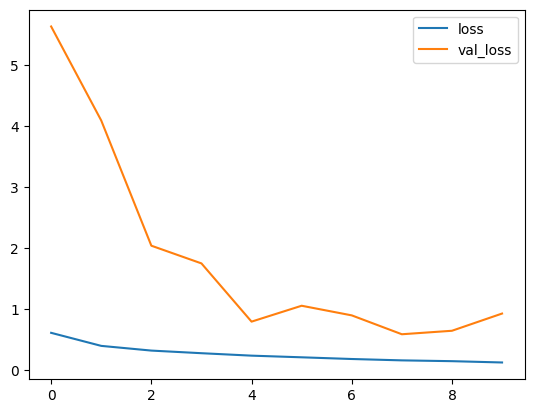

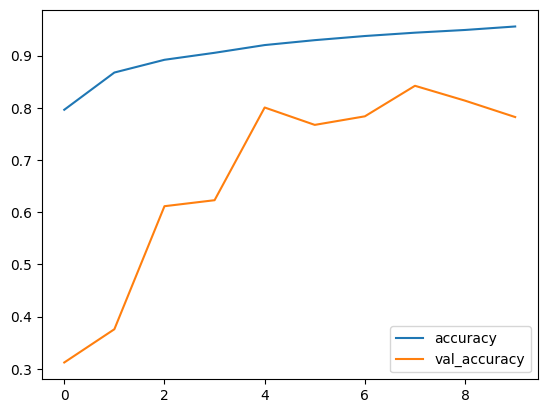

In [71]:
history_frame_mobilenet_trainable_applications = pd.DataFrame(history_mobilenet_trainable_applications.history)
history_frame_mobilenet_trainable_applications.loc[:, ['loss', 'val_loss']].plot()
history_frame_mobilenet_trainable_applications.loc[:, ['accuracy', 'val_accuracy']].plot();

#**Prediction**

In [ ]:
# 模型经过训练后，使用它对一些图像进行预测。附加一个 Softmax 层，将模型的线性输出 logits 转换成更容易理解的概率。
probability_model = tf.keras.Sequential([model,tf.keras.layers.Softmax()])

In [ ]:
predictions = probability_model.predict(test_images)

In [ ]:
print(predictions)

In [ ]:
# 将其绘制成图表，看看模型对于全部 10 个类的预测。
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [ ]:
# 看看第 0 个图像、预测结果和预测数组。正确的预测标签为蓝色，错误的预测标签为红色。数字表示预测标签的百分比（总计为 100）
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()